In [269]:
import stanza
import pandas as pd
import numpy as np
import re
stanza.download('pl', package='lfg')
nlp = stanza.Pipeline('pl', package='lfg')

2021-01-27 22:28:43 INFO: Downloading these customized packages for language: pl (Polish)...
| Processor | Package |
-----------------------
| tokenize  | lfg     |
| pos       | lfg     |
| lemma     | lfg     |
| depparse  | lfg     |
| pretrain  | lfg     |

2021-01-27 22:28:43 INFO: File exists: /home/jarczi/stanza_resources/pl/tokenize/lfg.pt.
2021-01-27 22:28:43 INFO: File exists: /home/jarczi/stanza_resources/pl/pos/lfg.pt.
2021-01-27 22:28:43 INFO: File exists: /home/jarczi/stanza_resources/pl/lemma/lfg.pt.
2021-01-27 22:28:44 INFO: File exists: /home/jarczi/stanza_resources/pl/depparse/lfg.pt.
2021-01-27 22:28:44 INFO: File exists: /home/jarczi/stanza_resources/pl/pretrain/lfg.pt.
2021-01-27 22:28:44 INFO: Finished downloading models and saved to /home/jarczi/stanza_resources.
2021-01-27 22:28:44 INFO: Loading these models for language: pl (Polish):
| Processor | Package |
-----------------------
| tokenize  | lfg     |
| pos       | lfg     |
| lemma     | lfg     |
| deppars

In [373]:
def get_sentiment(row, sentiment_dictionary):
    statement = removeAdditionalHashes(row.hashtag,row.content)
    doc = nlp(statement)
    sent_values = []
    
    for s in range(len(doc.sentences)):
        sent_values.append(list())
        for w in range(len(doc.sentences[s].words)):
            val = sentiment_dictionary.sentiment[sentiment_dictionary.word == doc.sentences[s].words[w].lemma]
            if(val.empty):
                sent_values[s].append(None)
            else:
                sent_values[s].append(int(val.values[0]))
    
    sent_modificators = []  
    for s in range(len(doc.sentences)):
        sent_modificators.append([1]*len(doc.sentences[s].words))
        for w in range(len(doc.sentences[s].words)):
            word = doc.sentences[s].words[w]
            
            if(word.pos == 'PART' and word.feats != None and word.feats.split('|').count('Polarity=Neg')>0):
                connected = [sub_word for sub_word in doc.sentences[s].words if sub_word.head == word.head]
                connected.append(doc.sentences[s].words[word.head -1]) 
                
                for sub_word in connected:
                    if sub_word.deprel != 'conj':
                        sent_modificators[s][sub_word.id-1] = -1 * sent_modificators[s][sub_word.id-1]
                
    norm = 0
    weights = 0
    for i in range(len(sent_values)):
        known_vals = [x for x in sent_values[i] if x is not None]
        n_known = len(known_vals)
        n_zeros = known_vals.count(0)
        sentence_weight = n_known/len(sent_values[i])
        weights += sentence_weight
        
        sent_values[i]= [val if val is not None else 0 for val in sent_values[i]]
        sent_modificators[i]= [val if val is not None else 1 for val in sent_modificators[i]]
        sent_values[i] = np.multiply(sent_modificators[i], sent_values[i])
        
        if n_known == 0:
            n_known = 1
        norm += sentence_weight * sum(sent_values[i])/(n_known - n_zeros*2/3)
    
    if weights == 0:
            weights = 1
    sentiment_norm = norm / weights
         
    if(sentiment_norm >= 0.2):
        return 1
    elif sentiment_norm <= -0.2:
        return -1
    else:
        return 0
    
    

def get_info(statement):
    doc = nlp(statement)
    
    for sentence in doc.sentences:
        for word in sentence.words:
            print(word.text, word.lemma, word.pos)
            if(word.pos == 'PART' and word.feats.split('|') != None and word.feats.split('|').count('Polarity=Neg')>0):
                print('ok')
            
    for sentence in doc.sentences:
        print(sentence.ents)
        print(sentence.dependencies)
        
    print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')

In [271]:
#Lemmatise csv and ovveride it. Input and output file has one columns ['content']
def lemmatise_strings_csv(input_file_name, output_file_name = 'output/output_'):
    raw = pd.read_csv(input_file_name, encoding = 'cp1250')
    sentiment_dictionary_adj = pd.DataFrame(columns=['word', 'sentiment'] )
    sentiment_dictionary_noun = pd.DataFrame(columns=['word', 'sentiment'] )
    sentiment_dictionary_verb = pd.DataFrame(columns=['word', 'sentiment'] )
    sentiment_dictionary_else = pd.DataFrame(columns=['word', 'sentiment'] )

    for i in range(len(raw['content']) ):
        if(i%100 == 0):
            print("Azure!: "+ str(i/100))
        raw_text = raw['content'][i]
        text = removeEmoji(removeUrl(removeSymbols(raw_text)))
        doc = nlp(text)
        
        for sentence in doc.sentences:
            for word in sentence.words:
                if(word.pos == 'ADJ'):
                    sentiment_dictionary_adj = sentiment_dictionary_adj.append({'word':word.lemma, 'sentiment':''}, ignore_index=True)
                elif(word.pos == 'VERB'):
                    sentiment_dictionary_verb = sentiment_dictionary_verb.append({'word':word.lemma, 'sentiment':''}, ignore_index=True)
                elif(word.pos == 'NOUN'):
                    sentiment_dictionary_noun = sentim'ent_dictionary_noun.append({'word':word.lemma, 'sentiment':''}, ignore_index=True)
                else:
                    sentiment_dictionary_else = sentiment_dictionary_else.append({'word':word.lemma, 'sentiment':''}, ignore_index=True)
                    
    sentiment_dictionary_adj = sentiment_dictionary_adj.drop_duplicates(subset=['word'])
    sentiment_dictionary_verb = sentiment_dictionary_verb.drop_duplicates(subset=['word'])
    sentiment_dictionary_noun = sentiment_dictionary_noun.drop_duplicates(subset=['word'])
    sentiment_dictionary_else = sentiment_dictionary_else.drop_duplicates(subset=['word'])
    
    sentiment_dictionary_adj.to_csv(output_file_name+'adj.csv', index = False)
    sentiment_dictionary_verb.to_csv(output_file_name+'verb.csv', index = False)
    sentiment_dictionary_noun.to_csv(output_file_name+'noun.csv', index = False)
    sentiment_dictionary_else.to_csv(output_file_name+'else.csv', index = False)

In [362]:
def removeEmoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def removeUrl(text):
    urls_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')                          
    return urls_pattern.sub(r'', text)

def removeSymbols(text):
    symbols_pattern = re.compile('[^AaĄąBbCcĆćDdEeĘęFfGgHhIiJjKkLlŁłMmNnŃńOoÓóPpRrSsŚśTtUuWwVvXxYyZzŹźŻż#.,0123456789]+' u'')                          
    return symbols_pattern.sub(r' ', text)

def removeAdditionalHashes(hashtag, text):
    arr = text.split(' ')
    while '' in arr:
        arr.remove('')
    
    hash_occured= False
    i = len(arr)-1
    if(i<0):
        return text.replace('#','')
        
    while arr[i][0] == '#':
        if arr[i].lower() != hashtag.lower() or hash_occured:
            arr.pop(i)
        else:
            hash_occured = True
        i -= 1
    
    text = ''
    for token in arr:
        text += token + ' '
    return text.replace('#','').lower()

****Tests****

In [371]:
tweets = pd.read_csv('tweets.csv')
dictionary = pd.read_csv('sentiment_dictionary.csv')

In [375]:
sentiment = []
for index, row in tweets_rated.iterrows():
    sent = get_sentiment(row,dictionary)
    sentiment.append(sent)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

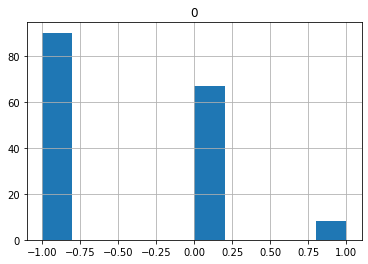

In [376]:
import matplotlib.pyplot
pd.DataFrame(sentiment).hist()